<a href="https://colab.research.google.com/github/aqwvinh/Basic_guideline_for_Machine_Learning/blob/master/Deep_Learning_HW2_Vinh_Nguyen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#@title Machine Learning modeling for Kaggle competition. Deep learning models are below (LSTM). 

In [0]:
!pip install -q torch skorch torchvision torchtext

     |████████████████████████████████| 122kB 9.3MB/s 


In [0]:
from sklearn import model_selection, preprocessing, linear_model, metrics, ensemble, svm, pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS


import pandas as pd, xgboost, numpy as np, textblob, string, nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import text, sequence
from keras.preprocessing.text import Tokenizer
from tensorflow.python.keras import layers, models, optimizers
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras import Sequential

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
nltk.download("punkt")
nltk.download("stopwords")
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, Adam
from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
# Import datasets
import os
os.environ['KAGGLE_USERNAME'] = "vinhnguyen94" # username from the json file
os.environ['KAGGLE_KEY'] = "ee939400b83c8ef989727a70f29fab39" # key from the json file
!kaggle competitions download -c hecmontrealdeeplearningcourse # api copied from kaggle

  0% 0.00/94.5k [00:00<?, ?B/s]
100% 94.5k/94.5k [00:00<00:00, 31.4MB/s]
  0% 0.00/69.5k [00:00<?, ?B/s]
100% 69.5k/69.5k [00:00<00:00, 67.4MB/s]
  0% 0.00/94.4k [00:00<?, ?B/s]
100% 94.4k/94.4k [00:00<00:00, 95.7MB/s]
  0% 0.00/561k [00:00<?, ?B/s]
100% 561k/561k [00:00<00:00, 37.0MB/s]
  0% 0.00/798k [00:00<?, ?B/s]
100% 798k/798k [00:00<00:00, 113MB/s]


In [0]:
# Datasets into Dataframe
train = pd.read_csv("train.csv")
text1 = pd.read_csv("text.csv.zip")
test = pd.read_csv("test.csv")
ref = pd.read_csv("reference.csv")

In [0]:
#@title Data preprocessing

In [0]:
# Incorporate references 
ref.rename(columns={'id':'identity'}, inplace=True)
ref.rename(columns ={ 'id.1': "id"}, inplace = True)
ref2 = pd.merge(ref, text1, on='id', how='inner')
ref2.rename(columns={'id':'id.1'}, inplace=True)
ref2.rename(columns ={ 'identity': "id"}, inplace = True)
ref2.rename(columns ={ 'title': "title"}, inplace = True)
ref2.sort_values('id', inplace= True)

new_ref = ref2.groupby('id')['title'].apply(' '.join).reset_index()

In [0]:
# Merge train id, label and title
new_train = pd.merge(train, text1, on='id', how='inner')
new_train

,id,label,title
0,0,1,interactive visual exploration of neighbor bas...
1,3,1,relational division four algorithms and their ...
2,6,1,simplifying xml schema effortless handling of ...
3,8,0,funbase a function based information managemen...
4,9,0,inverted matrix efficient discovery of frequen...
...,...,...,...
12774,25547,4,scaling up from dialogue to multilogue some pr...
12775,25548,3,a laboratory for the development and evaluatio...
12776,25554,2,an analysis of transformational analogy genera...
12777,25555,2,exploiting known taxonomies in learning overla...


In [0]:
# Merge train data with references
df_train = pd.merge(new_train, new_ref, on='id', how='left')
df_train['title_y'] = df_train['title_y'].fillna(" ")
df_train['title'] = df_train['title_x'] + df_train['title_y']
df_train = df_train.drop(["title_y","title_x"],1)
df_train

,id,label,title
0,0,1,interactive visual exploration of neighbor bas...
1,3,1,relational division four algorithms and their ...
2,6,1,simplifying xml schema effortless handling of ...
3,8,0,funbase a function based information managemen...
4,9,0,inverted matrix efficient discovery of frequen...
...,...,...,...
12774,25547,4,scaling up from dialogue to multilogue some pr...
12775,25548,3,a laboratory for the development and evaluatio...
12776,25554,2,an analysis of transformational analogy genera...
12777,25555,2,exploiting known taxonomies in learning overla...


In [0]:
# Merge test id and title
new_test = pd.merge(test, text1, on='id', how='inner')
new_test

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics
...,...,...
12777,25553,currency based updates to distributed material...
12778,25556,dynamic typing in a statically typed language
12779,25558,learning sparse metrics via linear programming
12780,25559,computer assisted reasoning with mizar


In [0]:
# Merge test data with references
new_test = pd.merge(new_test, new_ref, on='id', how='left')
new_test['title_y'] = new_test['title_y'].fillna(" ")
new_test['title'] = new_test['title_x'] + new_test['title_y']
new_test = new_test.drop(["title_y","title_x"],1)
new_test

,id,title
0,1,autodomainmine a graphical data mining system ...
1,2,anipqo almost non intrusive parametric query o...
2,4,selection and ranking of text from highly impe...
3,5,conditional random fields for multi agent rein...
4,7,multi dimensional description logics
...,...,...
12777,25553,currency based updates to distributed material...
12778,25556,dynamic typing in a statically typed languagea...
12779,25558,learning sparse metrics via linear programming...
12780,25559,computer assisted reasoning with mizar


Text(0.5, 1.0, 'Label distribution')

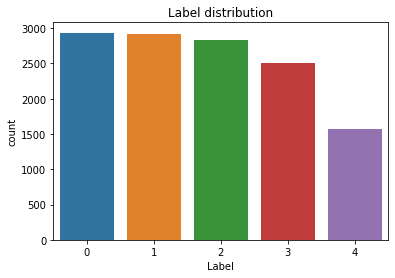

In [0]:
# Plot train labels
sns.countplot(df_train.label)
plt.xlabel('Label')
plt.title('Label distribution')

In [0]:
# Functions for preprocessing
def get_wordnet_pos(pos_tag):
    output = np.asarray(pos_tag)
    for i in range(len(pos_tag)):
        if pos_tag[i][1].startswith('J'):
            output[i][1] = wordnet.ADJ
        elif pos_tag[i][1].startswith('V'):
            output[i][1] = wordnet.VERB
        elif pos_tag[i][1].startswith('R'):
            output[i][1] = wordnet.ADV
        else:
            output[i][1] = wordnet.NOUN
    return output

def preprocessing_sentence(sentence):
    tokens = word_tokenize(sentence)
    tokens = [t.lower() for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stopwords.words("english")]
    words_tagged = nltk.pos_tag(tokens)
    tags = get_wordnet_pos(words_tagged)
    lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = [lemmatizer.lemmatize(w_t[0], pos=w_t[1]) for w_t in tags]
    return lemmatized_sentence

In [0]:
#Preprocessing on the train set
df_train["tokens"] = df_train.title.apply(preprocessing_sentence)
df_train

,id,label,title,tokens
0,0,1,interactive visual exploration of neighbor bas...,"[interactive, visual, exploration, neighbor, b..."
1,3,1,relational division four algorithms and their ...,"[relational, division, four, algorithm, perfor..."
2,6,1,simplifying xml schema effortless handling of ...,"[simplify, xml, schema, effortless, handle, no..."
3,8,0,funbase a function based information managemen...,"[funbase, function, base, information, managem..."
4,9,0,inverted matrix efficient discovery of frequen...,"[invert, matrix, efficient, discovery, frequen..."
...,...,...,...,...
12774,25547,4,scaling up from dialogue to multilogue some pr...,"[scale, dialogue, multilogue, principle, bench..."
12775,25548,3,a laboratory for the development and evaluatio...,"[laboratory, development, evaluation, bmd, sof..."
12776,25554,2,an analysis of transformational analogy genera...,"[analysis, transformational, analogy, general,..."
12777,25555,2,exploiting known taxonomies in learning overla...,"[exploit, know, taxonomy, learn, overlap, conc..."


In [0]:
X = df_train.tokens
y = df_train.label

In [0]:
# split the dataset into training and validation datasets 
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X, y, test_size=0.25, random_state=0,
                                                   stratify=y) #random_state to have the same alea and strafify to have a balance in label

In [0]:
# label encode the target variable 
encoder = preprocessing.LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_valid = encoder.fit_transform(y_valid)

In [0]:
#Initialize vectorizer with identity analyzer
vect = TfidfVectorizer(analyzer=lambda x: x)

#Get the tfidf (format in sparse matrix) to fit the model. fit_transform for train and transform for valid
X_train = vect.fit_transform(X_train)
X_valid = vect.transform(X_valid)


In [0]:
#Display the tfidf_1gram:
pd.DataFrame(X_train.toarray(), columns=vect.get_feature_names())

,aaa,aac,aadds,abandonment,abbreviate,abbreviation,abcd,abduction,abductiona,abductionupdates,abductive,abe,ability,abilitytesting,ablationleveraging,abnormal,abnormality,aboutlearning,aboutness,abridge,abridged,absence,absolute,abstract,abstracta,abstractdistributed,abstractexperiments,abstractfeature,abstractfrom,abstractinformia,abstractintegration,abstractinvestigating,abstraction,abstractiona,abstractionabstract,abstractionclient,abstractionimplementation,abstractionquickly,abstractionsmobile,abstractionssolving,...,xspect,xtag,xtango,xtra,xtraa,xtract,xtream,xvcl,xvm,xxl,yago,yahoo,yahoos,yahoosimultaneous,yale,yam,yap,year,yes,yesterday,yet,yield,yinyang,yor,youcurriculum,youre,youserv,youtube,yq,z,zbroker,zero,zeves,zipfs,zodiac,zone,zoo,zoom,zoomuserviews,zurich
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9579,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9580,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9582,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [0]:
# Model building. Following function is used to train a model and to compute the accuracy score
def train_model(classifier, train_vector, train_labels, valid_vector, valid_labels, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(train_vector, train_labels)
    
    # predict the labels on validation dataset
    predictions = classifier.predict(valid_vector)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)
    
    return metrics.accuracy_score(predictions, valid_labels)


In [0]:
# LR 1
accuracy1 = train_model(linear_model.LogisticRegression(random_state=0, penalty = "l2", solver='newton-cg', max_iter =200, C=1.6), X_train, y_train, X_valid, y_valid)
print ("LR 1: ", accuracy1)

# LR 2
accuracy2 = train_model(linear_model.LogisticRegression(random_state=0, penalty = "l2", solver='lbfgs', max_iter = 200, C=1.6), X_train, y_train, X_valid, y_valid)
print ("LR 2: ", accuracy2)

# LR 3
accuracy3 = train_model(linear_model.LogisticRegression(random_state=0, penalty = "l2", solver='saga', max_iter = 200, C=1.6), X_train, y_train, X_valid, y_valid)
print ("LR 3: ", accuracy3)

# SVM 1
accuracy4 = train_model(svm.SVC(C=10), X_train, y_train, X_valid, y_valid)
print ("SVM 1: ", accuracy4)

# SVM 2
accuracy5 = train_model(svm.SVC(C=2), X_train, y_train, X_valid, y_valid)
print ("SVM 2: ", accuracy5)

LR 1:  0.8028169014084507
LR 2:  0.8028169014084507
LR 3:  0.8028169014084507
SVM 1:  0.8115805946791862
SVM 2:  0.8112676056338028


Now, let's tune the hyperparameters

In [0]:
# Gridsearch
param_grid = {'C': [0.1,0.5,1,1.6],
              'solver': ['newton-cg', 'saga', 'lbfgs']
              } 
 
clf = model_selection.GridSearchCV(linear_model.LogisticRegression(), param_grid = param_grid, cv = 2, verbose=True, n_jobs=-1)

# Fit on data

best_clf = clf.fit(X_train, y_train)

Fitting 2 folds for each of 12 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:   10.0s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [0]:
print(clf.best_params_)

{'C': 1.6, 'solver': 'lbfgs'}


In [0]:
#print(clf.best_params_)

{'classifier': LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False), 'classifier__C': 1.623776739188721, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


Now, let's try our model on the test set

In [0]:
# Predictions with the best model
best_model = linear_model.LogisticRegression(random_state=0, penalty = "l2", solver='lbfgs', max_iter = 200, C=1.623776739188721)
best_model.fit(X_train, y_train)

LogisticRegression(C=1.623776739188721, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=200, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [0]:
#Preprocessing on test set
new_test["tokens"] = new_test.title.apply(preprocessing_sentence)
new_test

,id,title,tokens
0,1,autodomainmine a graphical data mining system ...,"[autodomainmine, graphical, data, mining, syst..."
1,2,anipqo almost non intrusive parametric query o...,"[anipqo, almost, non, intrusive, parametric, q..."
2,4,selection and ranking of text from highly impe...,"[selection, rank, text, highly, imperfect, tra..."
3,5,conditional random fields for multi agent rein...,"[conditional, random, field, multi, agent, rei..."
4,7,multi dimensional description logics,"[multi, dimensional, description, logic]"
...,...,...,...
12777,25553,currency based updates to distributed material...,"[currency, base, update, distribute, materiali..."
12778,25556,dynamic typing in a statically typed languagea...,"[dynamic, type, statically, type, languagean, ..."
12779,25558,learning sparse metrics via linear programming...,"[learn, sparse, metric, via, linear, programmi..."
12780,25559,computer assisted reasoning with mizar,"[computer, assist, reason, mizar]"


In [0]:
#Get tfidf for test set
X_test = vect.transform(new_test.tokens)

#Get predictions labels
y_pred = best_model.predict(X_test)

In [0]:
new_test["label"] = y_pred

In [0]:
output = new_test.drop(['title', 'tokens'],1)
output

,id,label
0,1,0
1,2,1
2,4,0
3,5,2
4,7,2
...,...,...
12777,25553,1
12778,25556,3
12779,25558,2
12780,25559,2


In [0]:
Final_output = pd.DataFrame(output).to_csv('LR_optimized_ref_last.csv', index = False)

In [0]:
#@title Deep Learning models: I haven't found better results with deep learning models but I leave you the code

In [0]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 40000
# Max number of words in each title.
MAX_SEQUENCE_LENGTH = 100
# This is fixed.
EMBEDDING_DIM = 50

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df_train.tokens.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16259 unique tokens.


In [0]:
X_lstm = tokenizer.texts_to_sequences(df_train.tokens.values)
X_lstm = pad_sequences(X_lstm, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_lstm.shape)

Shape of data tensor: (12779, 100)


In [0]:
Y_lstm = pd.get_dummies(df_train.label).values
print('Shape of label tensor:', Y_lstm.shape)

Shape of label tensor: (12779, 5)


In [0]:
X_train_lstm, X_valid_lstm, Y_train_lstm, Y_valid_lstm = train_test_split(X_lstm, Y_lstm, test_size = 0.2, random_state = 0, stratify = Y_lstm)
print(X_train_lstm.shape,Y_train_lstm.shape)
print(X_valid_lstm.shape,Y_valid_lstm.shape)

(10223, 100) (10223, 5)
(2556, 100) (2556, 5)


In [0]:
#LSTM structure

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping


model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_lstm.shape[1]))
model.add(SpatialDropout1D(0.6))
model.add(LSTM(64, dropout=0.6, recurrent_dropout=0.6))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [0]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 100, 50)           2000000   
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 100, 50)           0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                29440     
_________________________________________________________________
dense_6 (Dense)              (None, 5)                 325       
Total params: 2,029,765
Trainable params: 2,029,765
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Fit on the training data
history = model.fit(x = X_train_lstm,y = Y_train_lstm,batch_size=128,epochs=10,
          validation_split = 0.2, callbacks=[EarlyStopping(monitor='val_loss', patience = 3)])

Epoch 1/10
64/64 [==============================] - 37s 583ms/step - loss: 1.4698 - accuracy: 0.3674 - val_loss: 1.2995 - val_accuracy: 0.4303
Epoch 2/10
64/64 [==============================] - 36s 563ms/step - loss: 1.1968 - accuracy: 0.5202 - val_loss: 1.0047 - val_accuracy: 0.6337
Epoch 3/10
64/64 [==============================] - 36s 563ms/step - loss: 0.9253 - accuracy: 0.6610 - val_loss: 0.7328 - val_accuracy: 0.7403
Epoch 4/10
64/64 [==============================] - 36s 562ms/step - loss: 0.7069 - accuracy: 0.7515 - val_loss: 0.6531 - val_accuracy: 0.7589
Epoch 5/10
64/64 [==============================] - 35s 554ms/step - loss: 0.6225 - accuracy: 0.7797 - val_loss: 0.6007 - val_accuracy: 0.7848
Epoch 6/10
64/64 [==============================] - 36s 570ms/step - loss: 0.5661 - accuracy: 0.7982 - val_loss: 0.5969 - val_accuracy: 0.7829
Epoch 7/10
64/64 [==============================] - 36s 556ms/step - loss: 0.5206 - accuracy: 0.8201 - val_loss: 0.5765 - val_accuracy: 0.7966

In [0]:
accr = model.evaluate(X_valid_lstm,Y_valid_lstm)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

80/80 [==============================] - 3s 33ms/step - loss: 0.6542 - accuracy: 0.7817
Test set
  Loss: 0.654
  Accuracy: 0.782


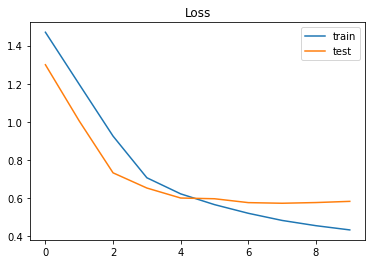

In [0]:
# Plot to monitor overfitting
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

In [0]:
# Make predictions
test_title = new_test.tokens
seq = tokenizer.texts_to_sequences(test_title)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)

#new_test['label']=""

for x in range(0,len(pred)):
  new_test.label[x] = np.argmax(pred[x])

new_test 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,id,title,tokens,label
0,1,autodomainmine a graphical data mining system ...,"[autodomainmine, graphical, data, mining, syst...",0
1,2,anipqo almost non intrusive parametric query o...,"[anipqo, almost, non, intrusive, parametric, q...",1
2,4,selection and ranking of text from highly impe...,"[selection, rank, text, highly, imperfect, tra...",0
3,5,conditional random fields for multi agent rein...,"[conditional, random, field, multi, agent, rei...",2
4,7,multi dimensional description logics,"[multi, dimensional, description, logic]",2
...,...,...,...,...
12777,25553,currency based updates to distributed material...,"[currency, base, update, distribute, materiali...",1
12778,25556,dynamic typing in a statically typed languagea...,"[dynamic, type, statically, type, languagean, ...",3
12779,25558,learning sparse metrics via linear programming...,"[learn, sparse, metric, via, linear, programmi...",0
12780,25559,computer assisted reasoning with mizar,"[computer, assist, reason, mizar]",2


Text(0.5, 1.0, 'Label distribution')

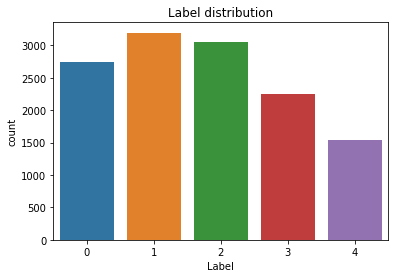

In [0]:
# Plot test labels
sns.countplot(new_test.label)
plt.xlabel('Label')
plt.title('Label distribution')

In [0]:
output = new_test.drop(['title', 'tokens'],1)
output

,id,label
0,1,0
1,2,1
2,4,0
3,5,2
4,7,2
...,...,...
12777,25553,1
12778,25556,3
12779,25558,0
12780,25559,2


In [0]:
Final_output = pd.DataFrame(output).to_csv('LSTM_softmax_ref.csv', index = False)